In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#está dando errado se tentar pegar as imagens do path images
files_path = [os.path.abspath(x) for x in os.listdir("./images/img400x_recorte_horizontal") if x.endswith('.png')]
print(files_path)

['/app/img400x_2.png', '/app/img400x_3.png', '/app/img400x_1.png']


In [88]:
# diretorio, arquivo = path, filename = os.path.split(files_path[0])
# print(arquivo)
# img = cv2.imread(arquivo)
# plt.imshow(img)
# plt.show()
images = []
for i in files_path:
    diretorio, arquivo = path, filename = os.path.split(i)
    print(arquivo)
    img = cv2.imread(arquivo)
    images.append(img)
#     plt.imshow(img)
#     plt.show()
    


img400x_2.png
img400x_3.png
img400x_1.png


In [89]:
# Demora muito tempo para imagens menores que 400x
stitcher = cv2.createStitcher()
status, stitched = stitcher.stitch(images)
print(status)

0


# Algoritmo stitcher do opencv

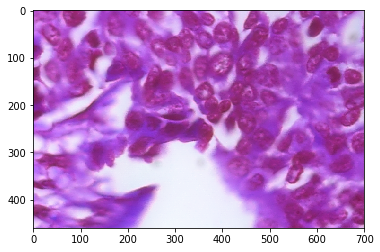

In [90]:
cv2.imwrite("output.png", stitched)
plt.imshow(stitched)
plt.show()

# ORB keypoints

In [91]:
# cv2.drawKeypoints está com erro em opencv 4.x, utilizar versão 3.4.5.20
a = []
kps1 = []
images = []

# disable OpenCL to because of bug in ORB in OpenCV 3.1
cv2.ocl.setUseOpenCL(False)

for i in files_path:
    diretorio, arquivo = path, filename = os.path.split(i)
    img = cv2.imread(arquivo)
    images.append(img)
    orb = cv2.ORB_create()
    

    
    keypoints, descriptors = orb.detectAndCompute(img, None)
    a.append(descriptors)
    kps1.append(keypoints)
    print(type(keypoints[0]))
#     img2 = cv2.drawKeypoints(img, keypoints, None, color=(0,255,0), flags=0)
    a.append(descriptors)
    kps1.append(keypoints)
#     a.append(descriptors)
#     img = cv2.drawKeypoints(img, keypoints, None)
#     print(type(descriptors))
    
#     plt.imshow(img2)
#     plt.show()



<class 'cv2.KeyPoint'>
<class 'cv2.KeyPoint'>
<class 'cv2.KeyPoint'>


OpenCV version: 3.4.2


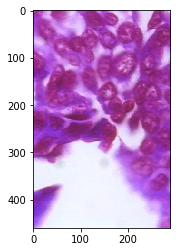

Creating Brute Force matcher
[[ 1.02723099e+00  7.00404777e-04  2.04600892e+02]
 [ 2.27064500e-02  1.00442510e+00 -1.18211513e+00]
 [ 7.89884227e-05  1.18821899e-06  1.00000000e+00]]


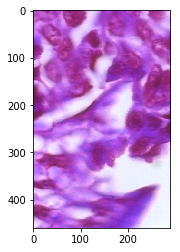

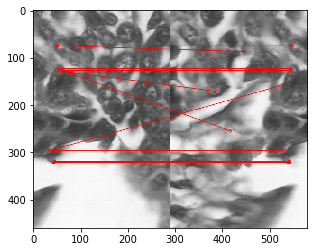

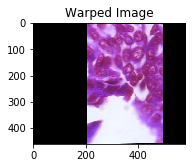

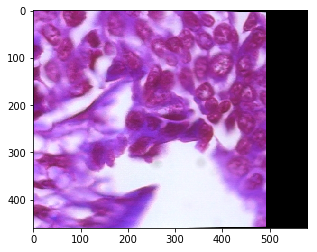

In [186]:
## ORB

print('OpenCV version: {}'.format(cv2.__version__) )


## Load images
queryImg = cv2.imread('img400x_2.png')
trainImg = cv2.imread('img400x_1.png')

plt.show()
plt.imshow(queryImg)

plt.show()
plt.imshow(trainImg)

## Convert to gray
grayQuery = cv2.cvtColor(queryImg, cv2.COLOR_BGR2GRAY)
grayTrain = cv2.cvtColor(trainImg, cv2.COLOR_BGR2GRAY)

## Creating orb detector
orb = cv2.ORB_create()
# orb = cv2.xfeatures2d.SIFT_create()


## Finding KPs and Descs
kpQuery, descQuery = orb.detectAndCompute(grayQuery, None)
kpTrain, descTrain = orb.detectAndCompute(grayTrain, None)

## Create Matcher
# matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matcher = cv2.BFMatcher()
print('Creating Brute Force matcher')

## Matching
# matches = matcher.match(descQuery, descTrain)
matches = matcher.knnMatch(descQuery, descTrain, k=2)

# Apply ratio test
good = []

for m in matches:
    if m[0].distance < 0.5*m[1].distance:
        good.append(m)

matches = np.asarray(good)

# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kpQuery[match[0].queryIdx].pt
    points2[i, :] = kpTrain[match[0].trainIdx].pt
    
# Find homography
h, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

print(h)



# Use homography
height, width, channels = trainImg.shape
im1Reg = cv2.warpPerspective(queryImg, h, (trainImg.shape[1] + queryImg.shape[1], trainImg.shape[0]) )

## Draw points
result = cv2.drawMatchesKnn(grayQuery, kpQuery, grayTrain, kpTrain,  matches[:10], None, (255,0,0), flags=2)

plt.show()
plt.imshow(result)
plt.show()


## Stitching
dst = cv2.warpPerspective(queryImg, h, (trainImg.shape[1] + queryImg.shape[1], trainImg.shape[0]) )
plt.subplot(122),plt.imshow(dst),plt.title('Warped Image')
plt.show()
plt.figure()

dst[0:trainImg.shape[0], 0:trainImg.shape[1]] = trainImg
cv2.imwrite('final.png',dst)
plt.imshow(dst)
plt.show()


